# TDT4173 - Group 10: EDA, feature engineering and models

`Group members`:
- Kaspar Paus Græsdal, 493880
- Oskar Holm, 527085
- Vegard Følstad Kolaas, 767941

In this notebook we ("[Group 10] Dunder Mifflin" on Kaggle) will elaborate upon our exploratory data analysis, and the different models we have tried out/used for this year's (2022) project in TDT4173.

## The project

The aim of this project is to predict revenues of a set of Norwegian businesses in 2016 provided a collection of data sets from the same year. This is in other words a regression problem, with the target being the `revenue` of the given businesses (the exact unit is not known, but presumably might be millions of NOK per year.).

## The data sets

As is standard for a problem like this, we have been provided with a training and testing data set, but also a number of auxiliary csv files. The first two files are `stores_train.csv` and `stores_test.csv`, and the rest are
- `stores_extra.csv`: Another data file with all the same variables as `stores_train.csv` and `stores_test.csv`, but without revenue, possibly useful for unsupervised learning techniques.
- `plaace_hierarchy.csv`: A data set categorising businesses on 4 different levels of specificity, 1 being the broadest with only 3 groups, and 4 being the most specific, with 109 different groups.
- `grunnkrets_norway_stripped.csv`: Geographical data on Norwegian grunnkretser, ie. "basic statistical units".
- `grunnkrets_age_distribution.csv`: Data on measured age distributions in each basic statistical unit.
- `grunnkrets_households_num_person.csv`: Data on the number of households in each statistical unit by category.
- `grunnkrets_income_households.csv`: Data on the median income per household type in each basic statistical unit.
- `busstops_norway.csv`: Info on Norwegian bus stops. 


### The basic data set

The first three csv files consists of the following variables.

* `store_id`: The unique identifier of the store in question. Should have no meaningful relationship with revenue.
* `revenue`: Our target variable.
* `year`: The year in which the data was measured. All values should be 2016, and as such should also be uninportant for prediction.
* `store_name`, `address`, `sales_channel_name`, `mall_name` and `chain_name`: Human-readable names for addresses, general business type, and, if applicable, the name of the mall and chain of the business in question.
* `plaace_hierarchy_id`: A string identifying the business' corresponding row in `plaace_hierarchy.csv`.
* `grunnkrets_id`: A string denoting the row of the basic statistical unit to which the business belongs in `grunnkrets_stripped.csv`. 
* `lat`: The store's latitude
* `lon`: The store's longitude


# Part 1: Importing libraries and data

These are the prerequisite libraries and functions needed to run this notebook.

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Here we load and summarise the basic data sets.

In [4]:
# Reading the basic datasets
df_train = pd.read_csv('data/stores_train.csv')
df_test = pd.read_csv('data/stores_test.csv')
df_all = pd.concat([df_train, df_test])


print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['revenue'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print('Train columns \n', list(df_train.columns))
print('Test columns \n', list(df_test.columns))

Number of Training Examples = 12859
Number of Test Examples = 8577

Training X Shape = (12859, 12)
Training y Shape = 12859

Test X Shape = (8577, 11)
Test y Shape = 8577

Train columns 
 ['store_id', 'year', 'store_name', 'plaace_hierarchy_id', 'sales_channel_name', 'grunnkrets_id', 'address', 'lat', 'lon', 'chain_name', 'mall_name', 'revenue']
Test columns 
 ['store_id', 'year', 'store_name', 'plaace_hierarchy_id', 'sales_channel_name', 'grunnkrets_id', 'address', 'lat', 'lon', 'chain_name', 'mall_name']


Retaining this smaller data frame (without all the supplementary data and/or the features to come) will help with readability in individual variable/feature EDA, but the full data set is loaded thus:

In [14]:
plaace_hierarchy_idspatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')
income = pd.read_csv('data/grunnkrets_income_households.csv').set_index(['grunnkrets_id', 'year']).add_prefix('income_').reset_index()
households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
plaace = pd.read_csv('data/plaace_hierarchy.csv')
busstops = pd.read_csv('data/busstops_norway.csv')
spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')

# Part 2: Exploratory Data Analysis (EDA), feature engineering and data cleaning

## 2.1 Exploring individual features/variables

### 2.1.1 Revenue

The most important single variable in the data set is naturally the `revenue`.

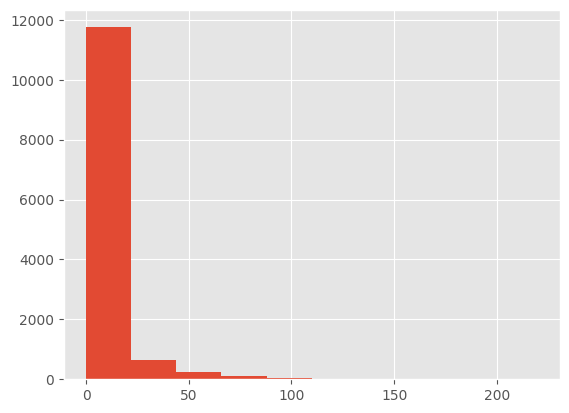

Standard quantiles: [  0.      1.195   3.374   7.996 219.599]
Mean: 8.220683101329808.


<AxesSubplot: >

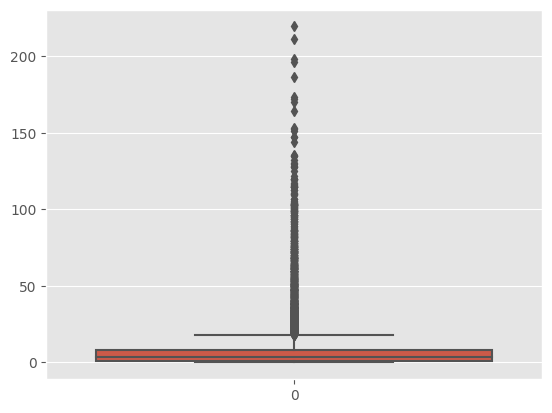

In [6]:
plt.hist(df_all["revenue"])
plt.show()

print(f'Standard quantiles: {np.quantile(df_train["revenue"], [0, 0.25, 0.5, 0.75, 1])}')
print(f'Mean: {np.mean(df_train["revenue"])}.')

sns.boxplot(df_train['revenue'])

**EDA insight 1**

The target distribution is extremely skewed. This is a problem as most of our models assume approximately normally distributed data. To deal with this we have decided to:

1. Transform the data to the log1 scale in order to lessen the skewness
2. Remove extreme values, namely those with with zero revenue and revenue greater than 100.

Length of data frame: 12859
Length after removing extreme values and zero revenue retail stores: 12574


<AxesSubplot: >

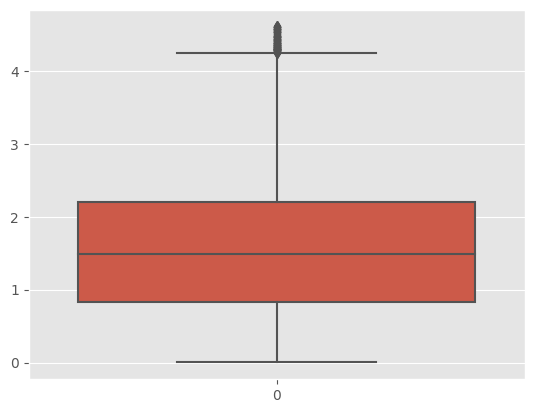

In [7]:
def clean(df: pd.DataFrame, min_val=0, max_val=100):
    print('Length of data frame:', len(df))
    df = df[(df.revenue > min_val) & (df.revenue < max_val)]
    print('Length after removing extreme values and zero revenue retail stores:',  len(df))
    # plt.hist(np.log1p(train.revenue), 30)
    # plt.show()
    return df.drop(columns=['revenue']), df.revenue


df_train, cleaned_revenue = clean(df_train)
df_train["revenue"] = cleaned_revenue


sns.boxplot(np.log1p(cleaned_revenue))

<AxesSubplot: xlabel='revenue', ylabel='Count'>

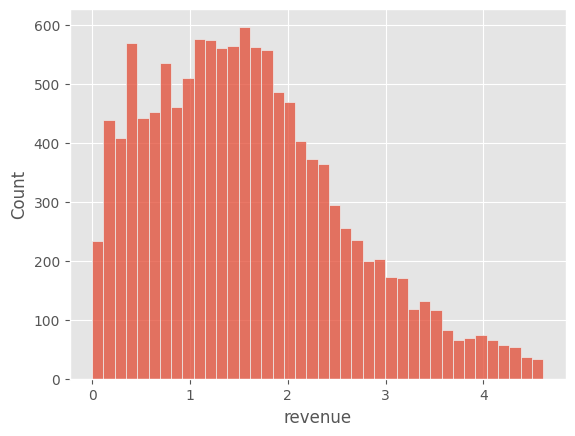

In [8]:
sns.histplot(np.log1p(cleaned_revenue))

As can be seen from the plots, this is much more feasible for inference.

Removing rows with 0 revenue might seem dubious on principle. It does not help that, as mentioned earlier, we do not know exactly what unit ``revenue`` is measured in, so intuiting what exactly 0 revenue means is far from trivial.

In any case trial and error with submission scores, suggests removing these rows is an improvement, and so we have decided to do so.

### 2.1.2 Age

**Engineered feature 1: Age groups**

Our first case of feature engineering concerns the age distribution data. By summarising the age data set we can see that it has an excessive number of columns, 93 to be exact.

In [9]:
age.head()

,grunnkrets_id,year,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,age_81,age_82,age_83,age_84,age_85,age_86,age_87,age_88,age_89,age_90
0,16013117,2015,14,14,14,14,13,13,12,11,...,0,0,0,0,0,0,0,0,0,0
1,16013117,2016,10,10,10,10,10,10,9,9,...,0,0,0,0,0,0,0,0,0,0
2,11030206,2015,5,5,5,5,5,4,4,3,...,0,0,0,0,0,0,0,0,0,0
3,16011203,2016,2,2,2,2,2,3,3,3,...,1,1,1,1,1,1,1,0,0,0
4,3011601,2016,7,7,7,7,6,6,5,4,...,1,1,0,0,0,0,0,0,0,0


To use this data as-is is clearly undesirable. Doing so would run into the curse of dimensionality, especially considering this problem overall already has a high number of potential variables/features.

Intuitively, the level of resolution present here is redundant. One would for instance not expect a substantially different impact from children aged 6 compared to children aged 10, or from adults aged 25 to 27, for instance. Therefore we instead make use of the following age groups:

In [10]:
age_ranges = [
    (0, 19),
    (20, 39),
    (40, 59),
    (60, 79),
    (80, 90),
]

def group_ages(age: pd.DataFrame, age_ranges):
    """
    Simplifies an age distribution data set so that it only counts persons in given age intervals
    Input:
        age: A pandas dataframe of the same format as the original csv. data
        age_ranges: An array of tuples representing intervals by which to group people
    Output: A pandas age dataframe whose columns are are the number of people with ages in the respective interval.
    """
    
    age_new = age[['grunnkrets_id', 'year']].drop_duplicates(subset=['grunnkrets_id'], keep='last')

    for rng in age_ranges:
        cols = [f'age_{age}' for age in range(rng[0], rng[1] + 1)]
        rng_sum = age[cols].sum(axis=1).astype(int)
        age_new[f'age_{rng[0]}_{rng[-1]}'] = rng_sum

    age = age.drop_duplicates(subset='grunnkrets_id').drop(columns=['year', *(f'age_{age}' for age in range(0, 91))], axis=1)
    age = age.merge(age_new.drop(columns=['year']), on='grunnkrets_id')

    return age

df_all = df_all.merge(group_ages(age, age_ranges), on='grunnkrets_id', how='left')

Through trial and error with our models, we also found that this improves inference, as expected.

### 2.1.3 Imputing NaNs from merging

Another major problem with the data as-is is the high number of NaN values, particularly NaNs that arise because the stores in question have no match in the supplementary data sets, ie. ``age.csv``, ``spatial`.csv``, ``income.csv`` and ``household.csv``. We have tried to remedy this with some imputations, for instance by replacing all NaNs from merging with ``spatial.csv`` with their own category, but we do not find that this helps with inference, so instead we simply remove these rows.

In [15]:
def clean_out_nan_heavy_rows(df: pd.DataFrame):
    """Cleans out rows that have no match in the age, spatial, income or household datasets."""

    df2 = df.merge(group_ages(age, age_ranges), on='grunnkrets_id', how='left')
    df2 = df2.merge(spatial.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(income.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(households.drop(columns=['year']), on='grunnkrets_id', how='left')

    df_cleaned = df[
        ~(df2.age_0_19_x.isna() | df2.couple_children_0_to_5_years.isna() | df2.grunnkrets_name.isna() | df2.income_all_households.isna())
    ]

    print(f'Cleaned out {len(df) - len(df_cleaned)} out of {len(df)} rows.')

    return df_cleaned

df_all = clean_out_nan_heavy_rows(df_all)

Cleaned out 1488 out of 21436 rows.


As can be seen from the printout message, doing this luckily did not remove that many rows.

### 2.1.4 ``sales_channel_name`` and Plaace hierarchy**  

[Insert and adapt old text and code here]

### 2.1.5 ``store_id``

To test some hypotheses about how the data set was split into test and training sets, we inspect the store IDs, but first, take note of the relative sizes of the raw training and test sets:

In [16]:
raw_train = pd.read_csv("data/stores_train.csv")
raw_test = pd.read_csv("data/stores_test.csv")
raw_total = pd.concat([raw_train, raw_test])

print(f"Size of training set: {len(raw_train)}.")
print(f"Size of test set: {len(raw_test)}.")
print(f"Ratio of test to train set size: {len(raw_test)/len(raw_train)}.")
print(f"Relative amount of training points: {len(raw_train)/len(raw_total)}")
print(f"Relative amount of testing points: {len(raw_test)/len(raw_total)}")

Size of training set: 12859.
Size of test set: 8577.
Ratio of test to train set size: 0.6670036550276072.
Relative amount of training points: 0.5998787087143124
Relative amount of testing points: 0.40012129128568763


We see that the respective proportions of training and test set are roughly 60/40. Were it not for this we could have guessed that stores were chosen based on modular-arithmetic operations on their IDs (ie. the test set could have consisted of every second, third, fourth store etc. after sorting them by ID).

To see if there might be some other trick at play, we can look at the distribution of ``store_id``.

In [17]:
raw_train["store_id"]

0         983540538-974187930-44774
1         987074191-973117734-44755
2         984890265-981157303-64491
3        914057442-992924179-126912
4        913018583-913063538-668469
                    ...            
12854    915789943-915806929-781991
12855    917921733-917982368-868081
12856    911721961-911764474-496764
12857    914337046-914343372-721294
12858    917494436-917551936-851089
Name: store_id, Length: 12859, dtype: object

We see that ``store_id`` is generally (if not categorically) a set of numbers separated by hyphens. Let's look at what they look like if we ``store_id`` into three different rows accordingly. We use log scale on column 3 because the histogram appears empty otherwise

In [38]:
# raw_total["store_id"].iloc[-2]
def split_store_id(df):
    id_col1 = []
    id_col2 = []
    id_col3 = []
    for i in range(len(df)):
        store_id_row = str(df["store_id"].iloc[i]).split("-")
        if len(store_id_row) > 3:
            indices_to_pop = []
            i = 0
            while len(store_id_row)-1 -i: #Not sure why, but some rows generates empty string elements, so we remove them here
                if not store_id_row[i]:
                    store_id_row.pop(i)
                else:
                    i += 1
        id_col1.append(int(store_id_row[0]))
        id_col2.append(int(store_id_row[1]))
        id_col3.append(int(store_id_row[2]))
    df["id_col1"] = id_col1
    df["id_col2"] = id_col2
    df["id_col3"] = id_col3
    return(df)
    pass

raw_total = split_store_id(raw_total)

# id_col1 = []
# id_col2 = []
# id_col3 = []
# for i in range(len(raw_total)):
#     store_id_row = str(raw_total["store_id"].iloc[i]).split("-")
#     if len(store_id_row) > 3:
#         indices_to_pop = []
#         i = 0
#         while len(store_id_row)-1 -i: #Not sure why, but some rows generates empty string elements, so we remove them here
#             if not store_id_row[i]:
#                 store_id_row.pop(i)
#             else:
#                 i += 1
#     id_col1.append(int(store_id_row[0]))
#     id_col2.append(int(store_id_row[1]))
#     id_col3.append(int(store_id_row[2]))
# raw_total["id_col1"] = id_col1
# raw_total["id_col2"] = id_col2
# raw_total["id_col3"] = id_col3

['912577465', '', '64561', '64561']
['915687180', '', '782154', '782154']
['917415927', '', '106244', '106244']
['988550205', '', '95873', '95873']
['998317177', '', '73749', '73749']
['915387195', '', '765271', '765271']
['914876192', '', '147931', '147931']
['882856682', '', '19504', '19504']
['989166905', '', '25378', '25378']
['988434558', '', '114712', '114712']
['995653346', '', '117520', '117520']
['913278704', '', '104082', '104082']
['817068952', '', '634913', '634913']
['960026640', '999369944', '', '999369944']
['991955739', '991993606', '', '991993606']
['992226986', '992265434', '', '992265434']
['992455675', '992555106', '', '992555106']
['995209713', '984698720', '', '984698720']
['980040208', '', '68038', '68038']
['937140894', '', '24214', '24214']
['977024250', '977344964', '', '977344964']
['996379396', '997673018', '', '997673018']
['912515494', '912531635', '', '912531635']
['989244140', '981185633', '', '981185633']
['997883462', '911555514', '', '911555514']
['98

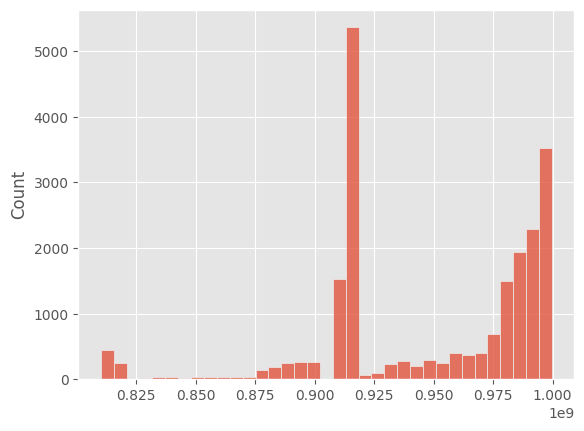

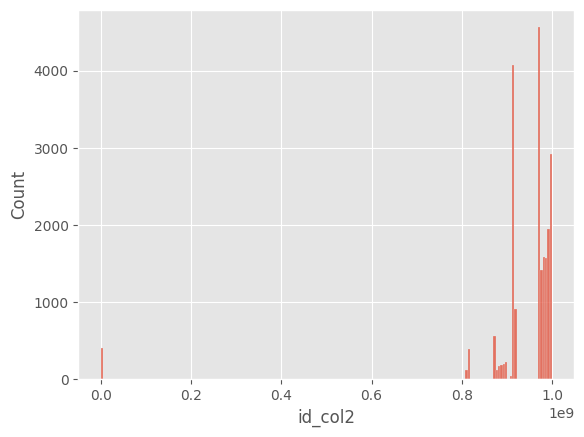

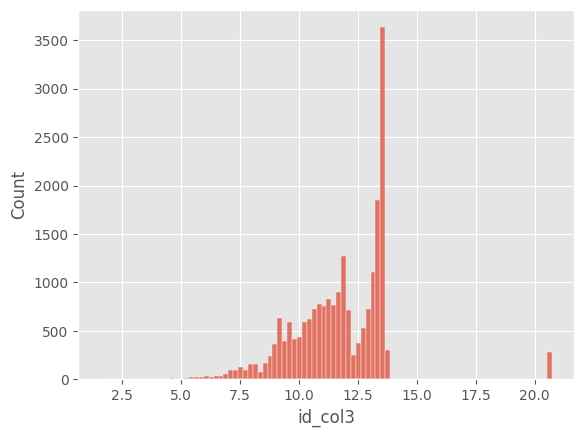

In [19]:
sns.histplot(raw_total["id_col1"])
plt.show()
sns.histplot(raw_total["id_col2"])
plt.show()
sns.histplot(np.log(raw_total["id_col3"]))
plt.show()

This seems interesting. From this we can see that the numbers are at least not uniformly random. It might be that store-id is chosen such that it has some qualitative information about the business in question, and we see distribution spikes because some types of businesses occur more than others.

These were the distributions for the complete data set. Let's quickly compare test and training set to see if any obvious differences appear then.

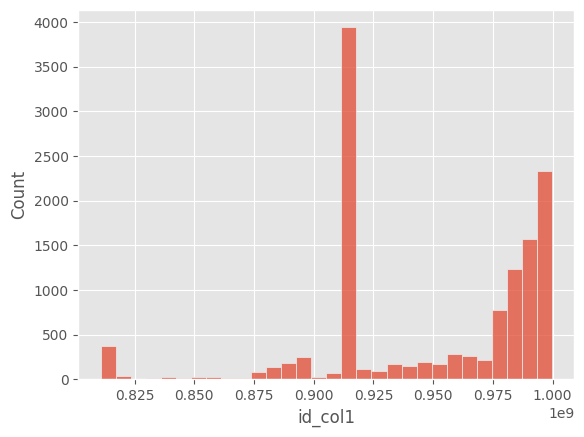

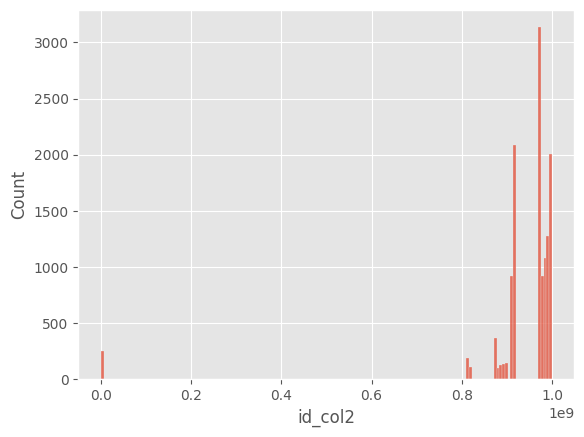

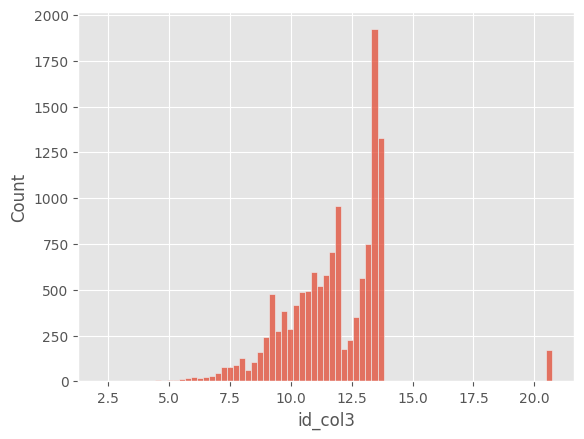

In [40]:
raw_train = split_store_id(raw_train)
sns.histplot(raw_train["id_col1"])
plt.show()
sns.histplot(raw_train["id_col2"])
plt.show()
sns.histplot(np.log(raw_train["id_col3"]))
plt.show()

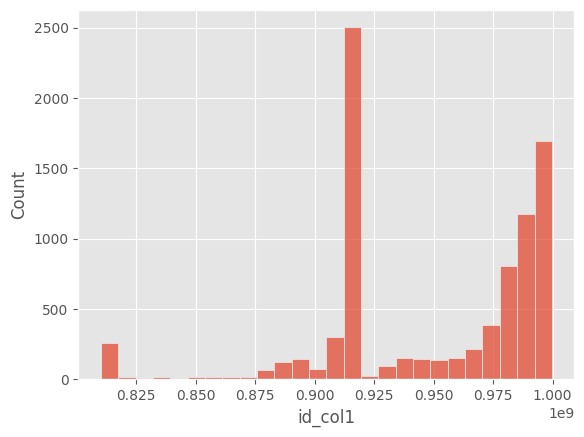

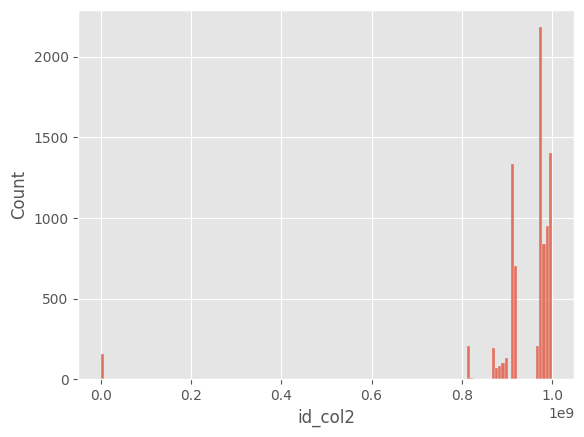

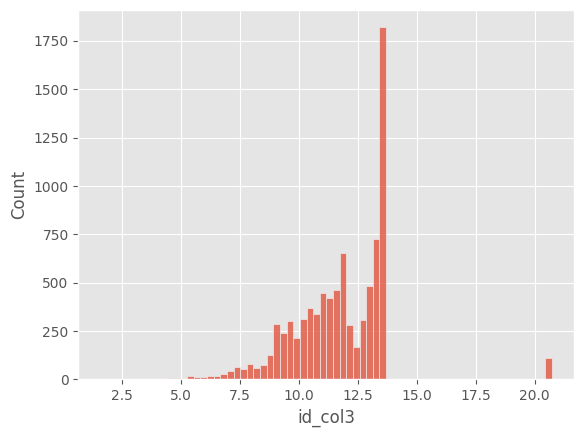

In [39]:
raw_test = split_store_id(raw_test)
sns.histplot(raw_test["id_col1"])
plt.show()
sns.histplot(raw_test["id_col2"])
plt.show()
sns.histplot(np.log(raw_test["id_col3"]))
plt.show()

The shape of both histograms appear relatively similar, so we have nothing to support the hypothesis that ```store_id`` plays a role in data generation so far.

### 2.2 Pairs and groups of variables

#### 2.2.1 ``lon``, ``lat`` and ``revenue``

Ideally, we want our data set to cover the entire country. Checking whether there is an obvious relationship between `lon` or `lat` and `revenue` would also be interesting. Finally, are there any glaring discrepancies between training and test sets in regards to these variables? We can quickly check for all of this with a couple of pairs plots:

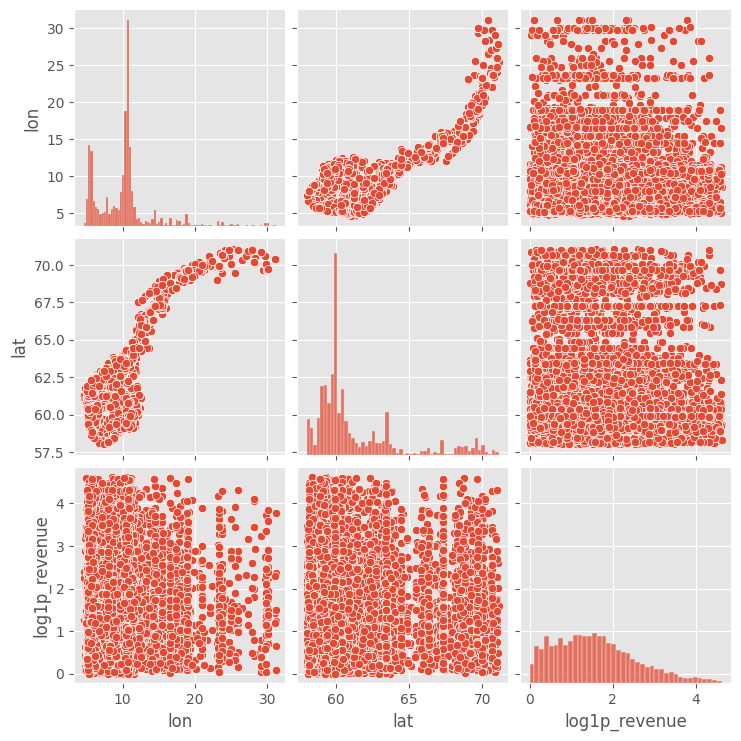

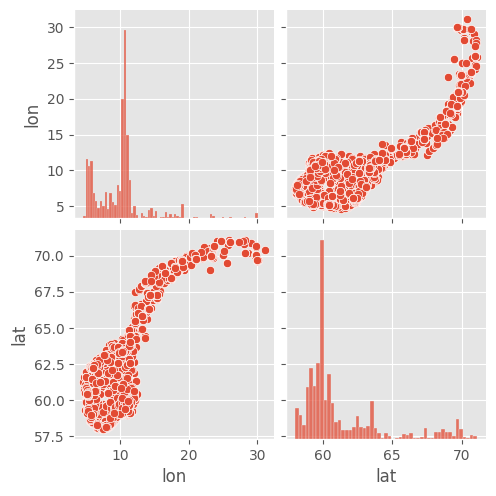

In [20]:
df_train["log1p_revenue"] = np.log1p(df_train["revenue"])
sns.pairplot(df_train, vars = ["lon", "lat", "log1p_revenue"])
sns.pairplot(df_test, vars = ["lon", "lat"])

From looking at the first plots of ``lat`` vs. ``lon`` we see that the dataset does indeed cover the entire country, as the collection of dots closely resembles a map of Norway. There also does not appear to be a glaring discrepancy between the test and training sets in regard to store locations, at least not any that can easily be seen from these plots.

Looking at the `lat` and `lon` histograms, the difference in geographical density becomes a lot more obvious. There are clearly far more stores near longitude 10 and latitude 60. From looking at the plots of ``lat``/``lon`` vs ``revenue`` we also see a relation to the skewness of ``revenue``, as
1. the ``revenue`` outlier values are found here, and
2. there seems to be more stores in the area overall.

We can look even closer at the difference between the test and training set, though, and one way of doing so is with a simple combined scatterplot of ``lon`` and ``lat``, this time with different colours for training and test set.

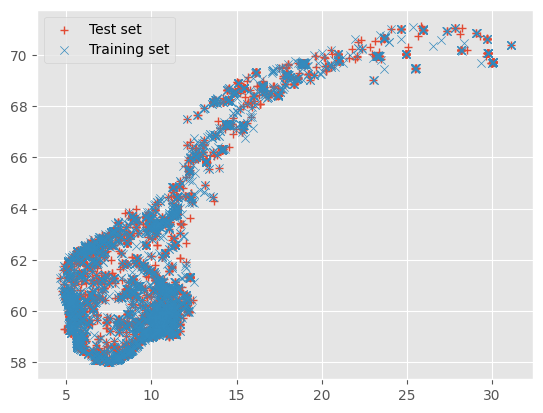

In [21]:
df_split_comparison = pd.concat([df_train, df_test])
df_split_comparison["Is_test"] = [False if i < len(df_train) else True for i in range(len(df_split_comparison))]

#sns.scatterplot(data = df_split_comparison, x = "lon", y = "lat", hue = "Is_test")

plt.scatter(df_test["lon"], df_test["lat"], linewidths=1, marker="+", label = "Test set")
plt.scatter(df_train["lon"], df_train["lat"], linewidths=0.5, marker="x", label = "Training set")
plt.legend()
plt.show()


This de-confirms the hypothesis that there is an obvious geopgraphical component to the data set split method.

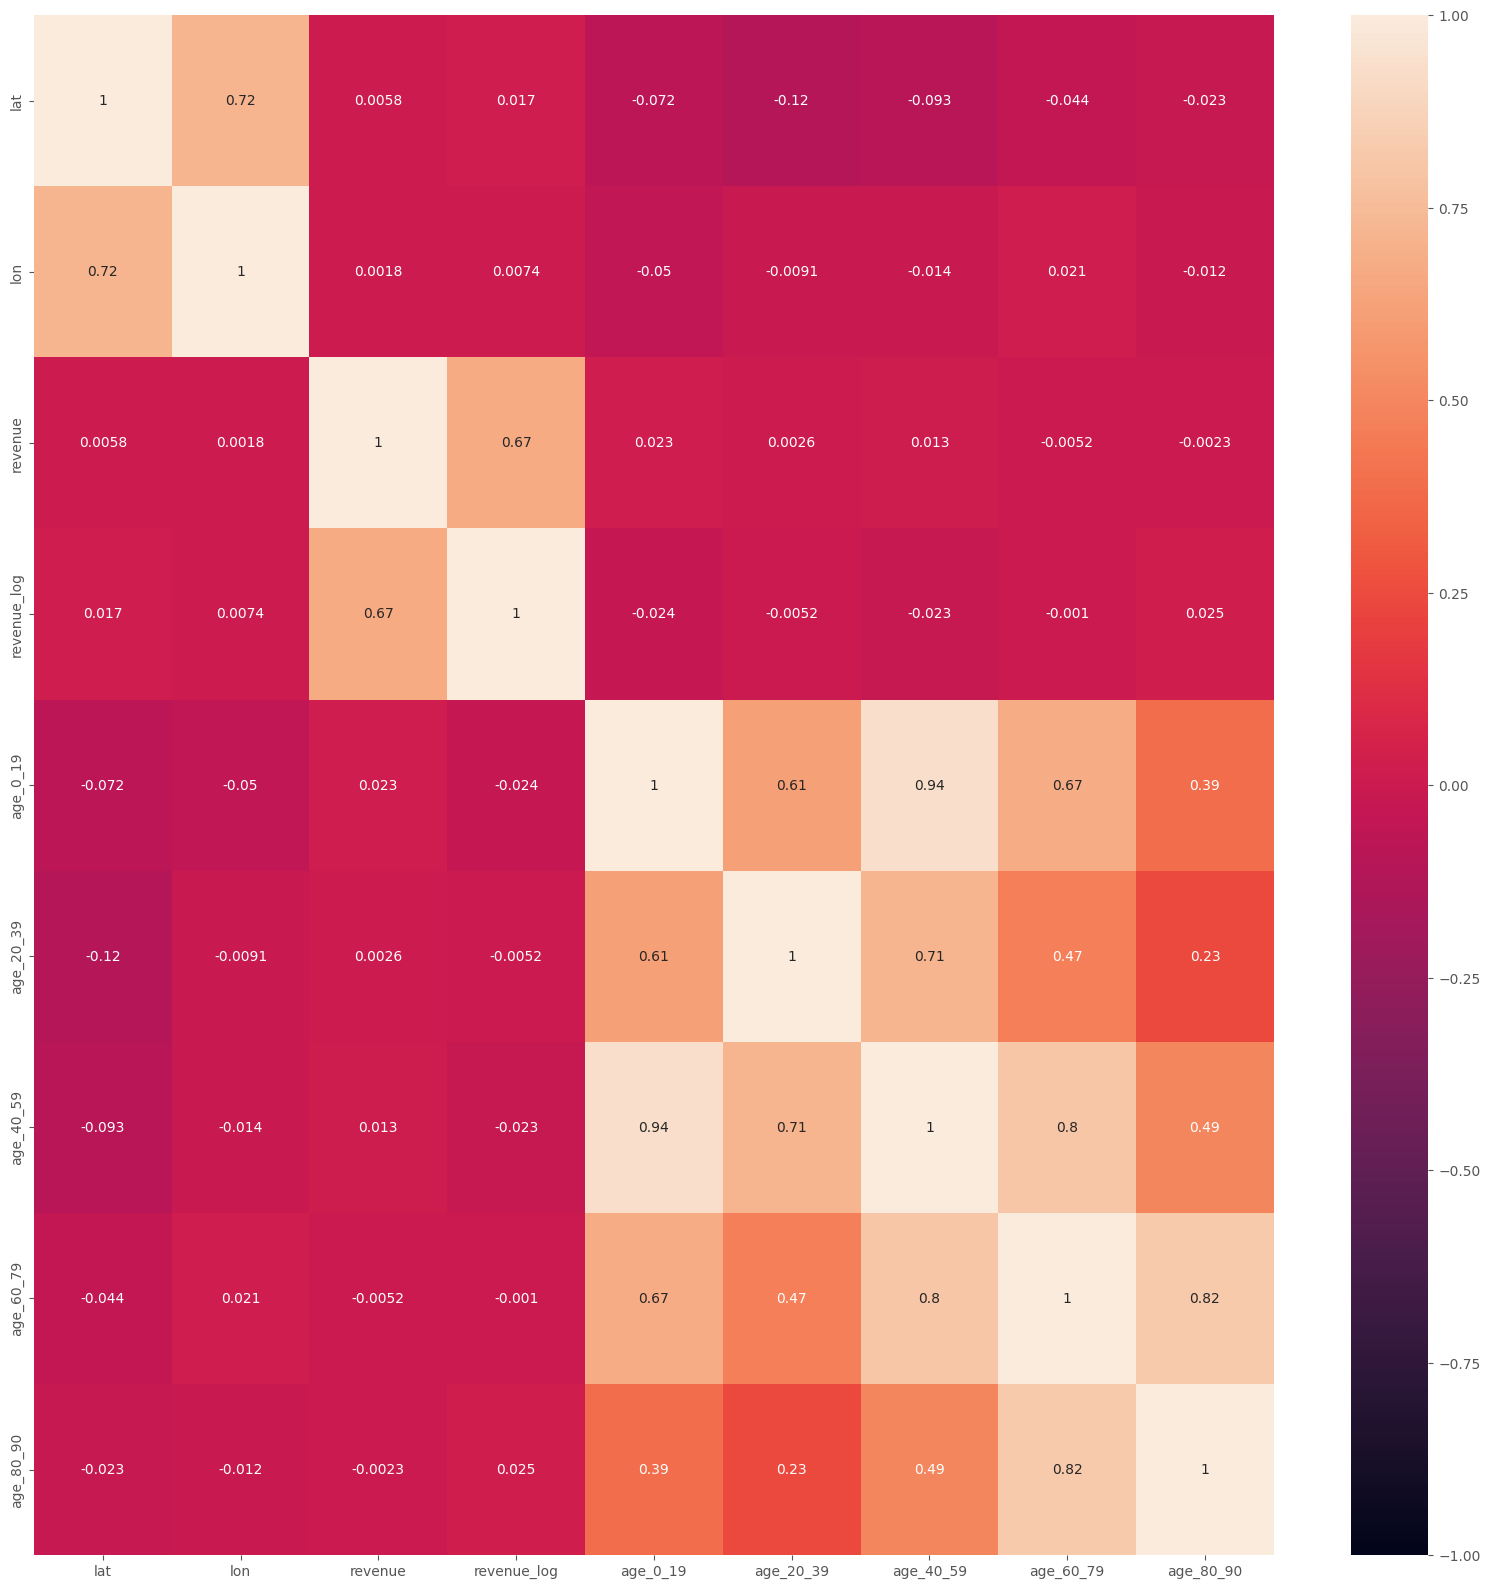

In [22]:
df_all['revenue_log'] = np.log(df_all['revenue'])

def plot_corr(data):
  df = data[['lat', 'lon', 'revenue', 'revenue_log', 'age_0_19', 'age_20_39', 'age_40_59', 'age_60_79', 'age_80_90']]
  plt.figure(figsize=(20, 20))
  
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

plot_corr(df_all)

This is a heatmap of latitude, longitude, revenue, logged revenue, age 0-19, age 20-39, age 40-59, age 60-79, age 80-90. Not surprisingly, the age groups have a high correlation. Specifically ages 80-90 and ages 60-79 have a high correlation, while age 80-90 have a low correlation with the ages of 20-39. The revenue has a low correlation with the age groups, and the latitude and longitude.

### 2.2.2 Distance from city centers using K means

We attempted to use kmeans to create clusters on stores, in order to find stores close to each other. We ran many clusterings, and chose the one that gave the best overall validation score. We then added a new feature called clusters, with the value of each predicted store and its cluster. This improved the score slighty, but we ended up dropping it. We got the idea to cluster based on the different plaace hierarchies (lv1 and lv2 mostly) and the extra dataset also, but ended up not pursuing it as the score did not improve. 

### 2.2.3 Nearby bus stop counts

#### 2.2.4 Nearby store count

Following a line of reasoning as the K means clustering, we suspected the number other stores in a given radius might be a useful feature.The underlying hypothesis is more or less the same: When several stores are close together, that tends to be mean there are more costumers around to support them. Ergo counting the number of nearby stores might be useful for inference.

## 3 Models

### 3.1 XGBoost

The first model our group used was XGBoost. One of our group members has done some machine learning before, and had good results with XGBoost.  However, after a certain point in feature engineering, we were unable to make improvements to our validation score. Our results were fluctuating a lot, as well. We figured out it was time to try out a new model at this point.

### 3.2 Catboost

Our second model used was Catboost. Our reasoning is simple: we wanted to try a new model, and an article suggested catboost. Apparently it could outperform XGBoost in some cases. This is where we had our biggest jumps in the kaggle scoreboard.

### 3.3 LightBGM

### 3.4 Auto SK learn

As picking a "best" model can be difficult, we attempted to use an AutoML library called auto-sklearn. After running the model with our feature engineered data and different parameters, we learned that gradient boosting and stochastic gradient descent were the "best" for this dataset. This confirmed what we were already experimenting with: catboost, xgboost and lightgbm. We started using AutoML late in the assignment, and in hindsight we should have started with AutoML in order to understand our data quicker. Here is the output of our auto-sklearn model, with the parameters that gave the best validation score:

| model_id | rank | ensemble_weight | type              | cost     | duration   |
|----------|------|-----------------|-------------------|----------|------------|
| 350      | 1    | 0.18            | gradient_boosting | 0.591483 | 80.090698  |
| 409      | 2    | 0.08            | sgd               | 0.592052 | 16.760684  |
| 302      | 3    | 0.18            | gradient_boosting | 0.592504 | 70.710302  |
| 470      | 4    | 0.08            | sgd               | 0.597122 | 10.189555  |
| 361      | 5    | 0.02            | sgd               | 0.597149 | 19.616134  |
| 388      | 6    | 0.24            | sgd               | 0.598301 | 30.819023  |
| 174      | 7    | 0.06            | gradient_boosting | 0.600266 | 216.026378 |
| 286      | 8    | 0.02            | gradient_boosting | 0.603568 | 61.844261  |
| 161      | 9    | 0.04            | gradient_boosting | 0.607548 | 82.662334  |
| 230      | 10   | 0.06            | gradient_boosting | 0.608876 | 26.738847  |
| 260      | 11   | 0.04            | gradient_boosting | 0.611695 | 47.306023  |


Data had to be changed to string, as auto-sklearn only worked with numeric or text data.

In [23]:
def handle_data(df: pd.DataFrame):
    for column in df:
        df[column] = df[column].astype(str)
    return df

The code used to create the auto-sklearn model.

In [24]:
def auto_ml(total_time, per_run_time):
    print("Attempting to start AutoML model...")
    model = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=total_time,
        per_run_time_limit=per_run_time,
        n_jobs=-1,
        memory_limit=32000)
    print("Model started.")
    print("Attempting to fit model...")
    model.fit(handle_data(X_train), y_train, X_test=handle_data(X_val), y_test=y_val)
    print(model.leaderboard())
    print("Model fit.")
    print("Attempting to predict model...")
    y_hat = model.predict(handle_data(X_val))
    y_test_pred = np.expm1(model.predict(handle_data(X_test)))
    y_pred = np.expm1(y_hat)
    print("Model predicted.")
    acc = rmsle(y_pred, np.expm1(y_val))
    print(f"Model Accuracy:{acc}")
    return model

## 4 Hyperparameter tuning

As hyperparamater tuning is extremely important for a model to function optimally, we used libraries that did the tuning for us. We used random k fold with RandomizedSearchCV, and split our dataset into 80% train and 20% validation. By running this model, we found the most optimal parameters, we thought. As random k fold had its limitations, so we opted for Optuna instead, that gave even better hyperparameters. Here is an example of our Optuna model working:

| Trial                           | RMSLE score         | Parameters                                                                                                                                                                                         | Best Trial                                      |
|---------------------------------|---------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------|
| Trial 197 finished with value:  | 0.7203855872925886  | and parameters: {'lambda_l1': 2.7625726622938257e-06, 'lambda_l2': 5.974059396329312, 'num_leaves': 7, 'feature_fraction': 0.9540381054695006, 'min_child_samples': 96, 'boosting_type': 'gbdt'}.  | Best is trial 67 with value: 0.720211809513416. |
| Trial 198 finished with value:  | 0.7244371834775267  | and parameters: {'lambda_l1': 3.370376083398259e-06, 'lambda_l2': 6.587299063520444, 'num_leaves': 19, 'feature_fraction': 0.9570930427207726, 'min_child_samples': 100, 'boosting_type': 'gbdt'}. | Best is trial 67 with value: 0.720211809513416. |

The model ran several trials i.e. runs, with different hyperparameters. We used the hyperparameters from the best trial.

## 5 Stacking

# Old code and text below this line -------------------------------------

## 2.3 Explore pairs and groups


NaNs (in the basic data sets) only occur in the columns "address", "chain_name" and "mall_name". Moreover, they occur in the test set as well as the training set, so unless we find some good way of handling them, we will likely lose performance.

Dropping the rows that contain them seems out of the question, as we only have ~1500 out of 12859 non-NaNs in 'mall_name'.

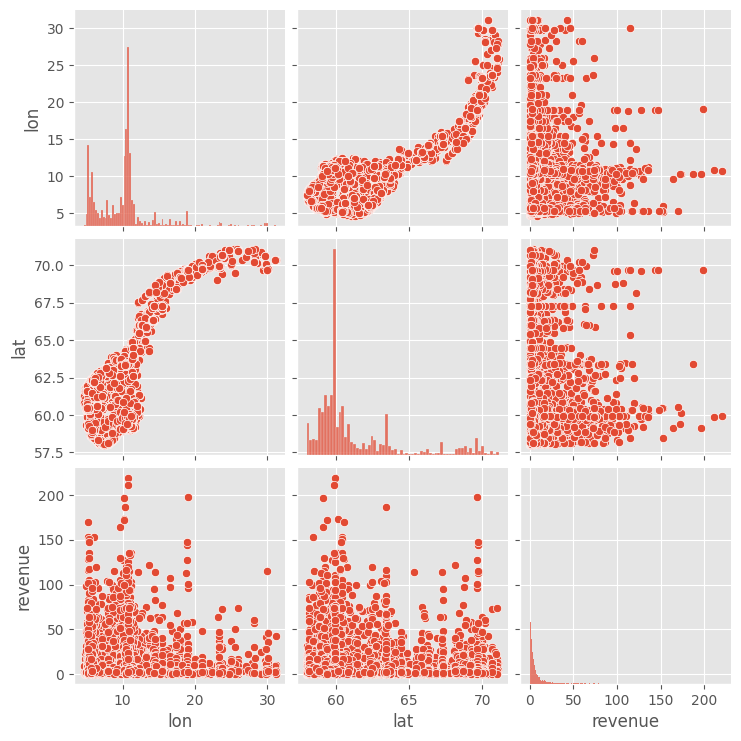

In [25]:
sns.pairplot(df_all, vars = ["lon", "lat", "revenue"])

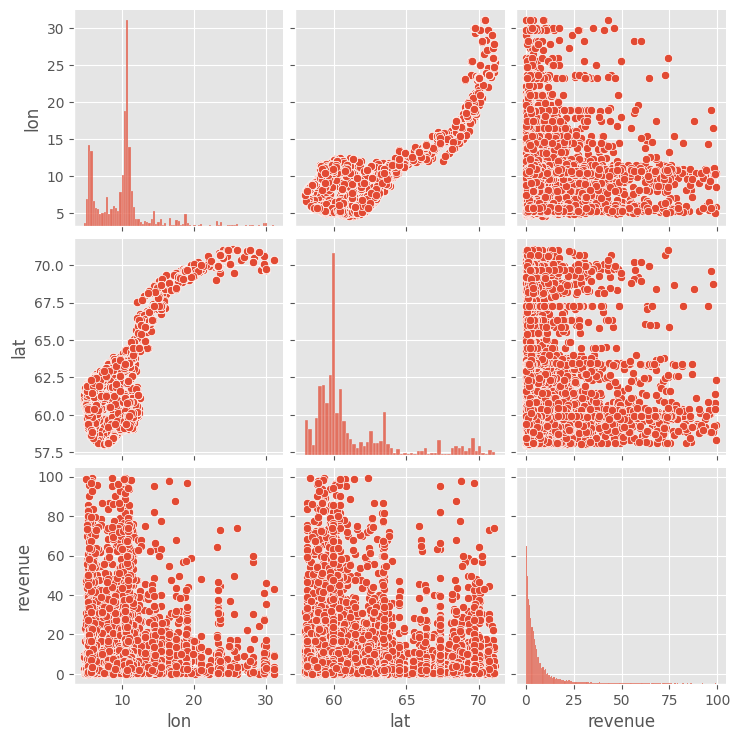

In [26]:
sns.pairplot(df_train, vars = ["lon", "lat", "revenue"])

From these pairplots we can make the following observations:

**EDA observation 1**

From looking at the logitude vs. latitude plots, as well as the latitude/longitude histograms, we see that although our data set contains businesses all over the country, their density across it is also quite skewed. In particular, there are large spikes around latitude 10 and longitude 60, and comparetively few stores far north and east. This applies for both the training and the test set.


**EDA observation 2**

There is clearly some type of relationship between revenue and longitude/latitude, though it is noisy, and might have some outliers. Once again we will need to inspect more closely to maybe gain more insight.

The two spikes noted under observation 2 also appear here. It might be worth trying to check whether this is because there are simply so many stores near these coordinates and some simply got lucky, if businesses there in fact tend to be more profitable, and/or if some of the variation is better explained by other variables.

#### Looking closer at `revenue`

Our pairs plot seemed to indicate our target variable was very unevenly distributed. We can check this using a box plot:

<AxesSubplot: >

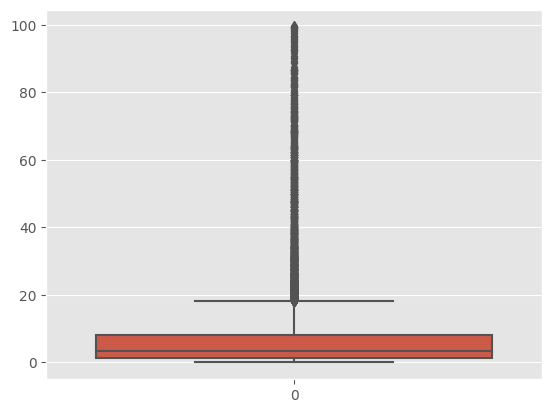

In [27]:
sns.boxplot(df_train['revenue'])

This confirms our suspicion. The overwhelming majority of data points are exactly, or very very close to 0. This makes prediction substantially harder. Transforming the target might help. We know from experience that a log transformation might be useful, as it naturally "stretches" out point distributions like this.

<AxesSubplot: xlabel='log_revenue', ylabel='Count'>

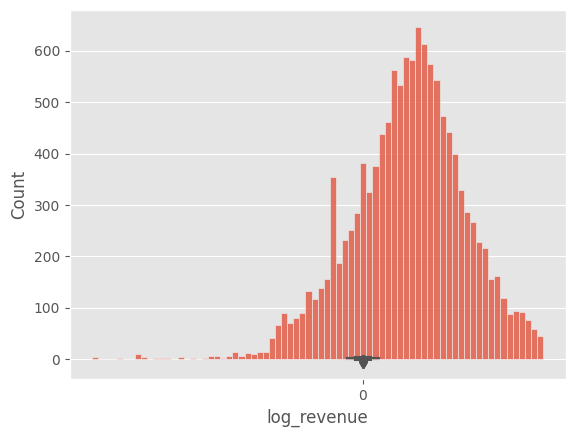

In [28]:
df_train["log_revenue"] = np.log(df_train["revenue"])
sns.boxplot(df_train["log_revenue"])
sns.histplot(df_train["log_revenue"])


<AxesSubplot: xlabel='root_revenue', ylabel='Count'>

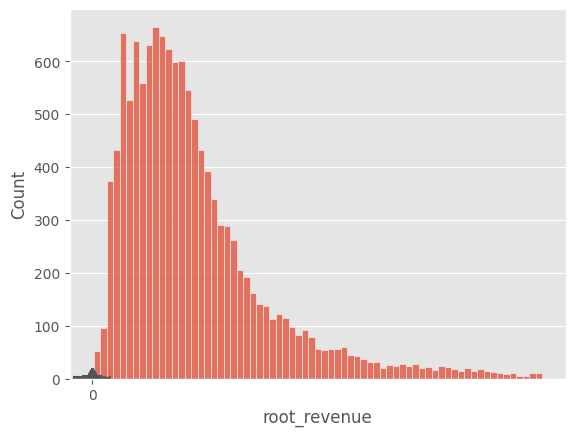

In [29]:
df_train["root_revenue"] = np.sqrt(df_train["revenue"])
sns.boxplot(df_train["root_revenue"])
sns.histplot(df_train["root_revenue"])

<AxesSubplot: xlabel='cube_root_revenue', ylabel='Count'>

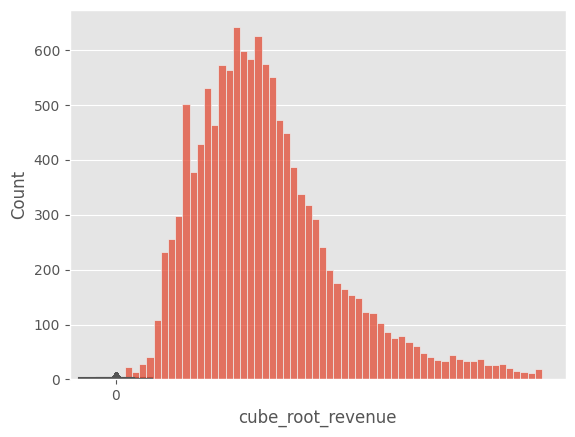

In [30]:
df_train["cube_root_revenue"] = np.cbrt(df_train["revenue"])
sns.boxplot(df_train["cube_root_revenue"])
sns.histplot(df_train["cube_root_revenue"])

This looks much better. Let's look at the pairs plot using this transformation.

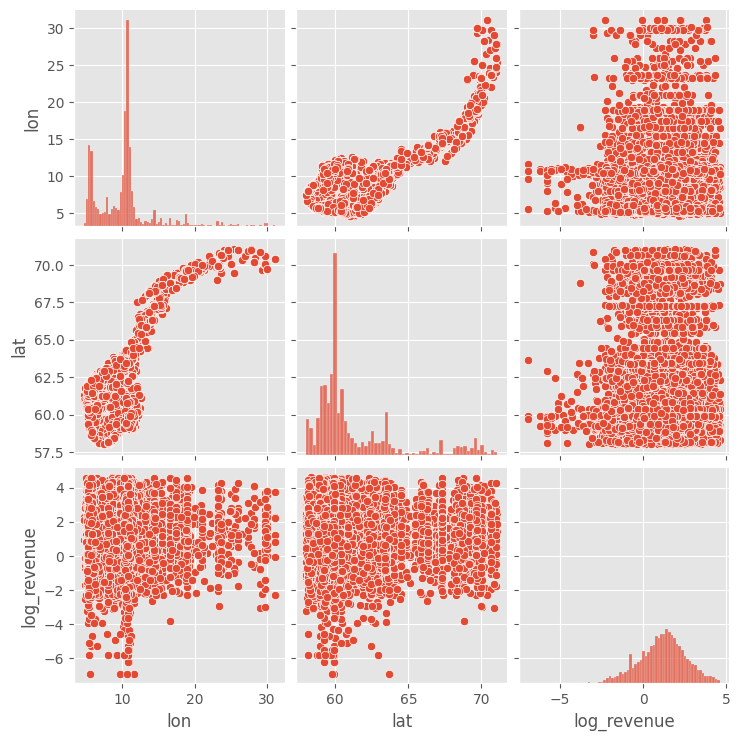

In [31]:
sns.pairplot(df_train, vars = ["lon", "lat", "log_revenue"])

The distribution of transformed revenue to other variables now looks much more closer to being normal, which should make model training more effective.

### Supplementary data

As stated previously we have also been provided with a number of supplementary data files. The first we will look at is `extra_stores.csv`...

**Note to self**:
Check whether grunnkrets ID is strictly increasing with latitude.

In [32]:
print(len(pd.read_csv('data/stores_extra.csv')))


28684


#### Exploring categorical variables

Our data has a lot of categorical variables, which can potentially cause difficulties during modelling. High dimentionality can be a particular culprit, so it might help to look at the data per se to formulate hypotheses about meaningful relationships.

Let's first consider the categorial variables present in the basic data sets.

In [33]:
df_all.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,age_0_19,age_20_39,age_40_59,age_60_79,age_80_90,revenue_log
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,27.0,69.0,38.0,20.0,3.0,2.890261
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,NaN,NaN,NaN,NaN,NaN,3.170861
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,72.0,154.0,62.0,73.0,11.0,2.778757
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,60.0,215.0,146.0,77.0,16.0,2.229584
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,NaN,NaN,NaN,NaN,NaN,1.510280


We can immediately see that the data set contains a number of McDonald's and Burger King restaurants.

Counting the number of each is easy enough:

In [34]:
mc_D_rows = df_all[df_all['chain_name'].str.contains('MCDONALD', na = False)]
print(f"Number of McDonald's restaurants in data set:", len(mc_D_rows), ".")

BK_rows = df_all[df_all['chain_name'].str.contains('BURGER KING', na = False)]
print(f"Number of Burger King restaurants in data set:", len(BK_rows), ".")

Number of McDonald's restaurants in data set: 2 .
Number of Burger King restaurants in data set: 13 .


It turns out there are not that many of either.

It also seems that iteratively going through the basic data set like this will be way too much work, so let's look at the supplementary Plaace hierarchy data instead.

In [35]:
plaace_hierarchy = pd.read_csv("data/plaace_hierarchy.csv")
df_all = df_all.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
df_all.head().T

,0,1,2,3,4
store_id,983540538-974187930-44774,987074191-973117734-44755,984890265-981157303-64491,914057442-992924179-126912,913018583-913063538-668469
year,2016,2016,2016,2016,2016
store_name,MCDONALD'S BRAGERNES TORG MAGASINET,MCDONALD'S KLINGENBERGGATA,BURGER KING HØNEFOSS,BURGER KING GLASSHUSPASSASJEN,BURGER KING TILLERTORGET
plaace_hierarchy_id,1.1.1.0,1.1.1.0,1.1.1.0,1.1.1.0,1.1.1.0
sales_channel_name_x,Hamburger restaurants,Hamburger restaurants,Hamburger restaurants,Hamburger restaurants,Hamburger restaurants
grunnkrets_id,6020303,3010306,6050102,18040102,16017414
address,BRAGERNES TORG 13,NaN,KONG RINGS GATE 1,STORGATA 12,NaN
lat,59.743104,59.913759,60.164751,67.283669,63.358068
lon,10.204928,10.734031,10.254656,14.379796,10.374832
chain_name,MCDONALDS,MCDONALDS,BURGER KING,BURGER KING,BURGER KING


Using this, we can gain an intuition for what kind of businesses with which we are working by identifying all the unique descriptions for each hierarchy level.

**Observation**: At a glance it looks as though the `sales_channel_name` column might be redundant. All of it's values in the head subset match `lv4_desc_y`. This should be relatively easy to check whilst inspecting Plaace hierarchy descriptions.

As a sanity check we print out the number of unique level 4 categories, as the introduction notebook said there should be 109 of them.

In [36]:
#Merge all the data
spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
stores_with_grunnkrets = df_all.merge(spatial, how='left', on='grunnkrets_id')

stores_with_grunnkrets.head()
#sum(stores_with_grunnkrets["municipality_name"].isnull())

stores_with_grunnkrets = stores_with_grunnkrets.drop("address", axis = 1)
stores_with_grunnkrets = stores_with_grunnkrets.drop("mall_name", axis = 1)
stores_with_grunnkrets = stores_with_grunnkrets.drop("chain_name", axis = 1)
stores_with_grunnkrets[stores_with_grunnkrets.isna().any(axis=1)]
sum(stores_with_grunnkrets["grunnkrets_name"].isnull())

54

In [37]:
lv1_descs = df_all['lv1_desc_y'].drop_duplicates()
lv1_descs = lv1_descs.T.drop_duplicates().T
print(f"Number of unique level one descriptions:", len(lv1_descs), ".")

lv2_descs = df_all['lv2_desc_y'].drop_duplicates()
lv2_descs = lv2_descs.T.drop_duplicates().T
print(f"Number of unique level 2 categories: ", len(lv2_descs), ".")

lv3_descs = df_all['lv3_desc_y'].drop_duplicates()
lv3_descs = lv3_descs.T.drop_duplicates().T
print(f"Number of unique level 3 categories: ", len(lv3_descs), ".")


lv4_descs = df_all['lv4_desc_y'].drop_duplicates()
lv4_descs = lv4_descs.T.drop_duplicates().T
print(f"Number of unique level 4 categories: ", len(lv4_descs), ".")


KeyError: 'lv1_desc_y'

This seems off. The introduction notebook mentions 109 different level 4 categories.

Let's check whether the rest feature in the extra data set.

In [ ]:
df_extra = pd.read_csv("data/stores_extra.csv")
df_extra = df_extra.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
df_full = pd.concat([df_all, df_extra], ignore_index=True)

lv1_descs = df_full['lv1_desc_y'].drop_duplicates()
lv1_descs = lv1_descs.T.drop_duplicates().T
print(f"Number of unique level one descriptions:", len(lv1_descs), ".")

lv2_descs = df_full['lv2_desc_y'].drop_duplicates()
lv2_descs = lv2_descs.T.drop_duplicates().T
print(f"Number of unique level 2 categories: ", len(lv2_descs), ".")

lv3_descs = df_full['lv3_desc_y'].drop_duplicates()
lv3_descs = lv3_descs.T.drop_duplicates().T
print(f"Number of unique level 3 categories: ", len(lv3_descs), ".")


lv4_descs = df_full['lv4_desc_y'].drop_duplicates()
lv4_descs = lv4_descs.T.drop_duplicates().T
print(f"Number of unique level 4 categories: ", len(lv4_descs), ".")

#NOTE to self: Check if the error disappears when only concatenating the extra set with the training set.




InvalidIndexError: Reindexing only valid with uniquely valued Index objects